In [94]:
import sys
import os
import time
sys.path.append(os.path.abspath('../..'))

from rcgp.morcgp import MOGPRegressor, MORCGPRegressor, MOGPRegressor_NC, MORCGPRegressor_NC, MORCGPRegressor_NC_fixed_weights, MORCGPRegressor_fixed_weights, MORCGPRegressor_PM
from rcgp.rcgp import RCGPRegressor
from rcgp.kernels import ConstantMean, RBFKernel, SineMean
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler

plt.rcParams.update({
    "text.usetex": True,         
    "font.family": "serif",       
    "text.latex.preamble": r"\usepackage{amsmath}",
    'font.size': 28,         
    'axes.labelsize': 28,    
    'axes.titlesize': 30,      # <-- Add this line for title size
    'xtick.labelsize': 24,   
    'ytick.labelsize': 24,  
    'legend.fontsize': 24,
    'lines.linewidth': 5,    
    'lines.markersize': 6   
})

In [95]:
def generate_A(d, r=1, base_strength=1.0, noise_level=0.1, seed=None):
    if seed is not None:
        np.random.seed(seed)
    # Shared signal: induces positive correlations
    shared_component = base_strength * np.ones((d, r))
    # Small random noise to avoid exact collinearity
    noise = noise_level * np.random.randn(d, r)
    A = shared_component + noise
    return A

def calculate_rmse(y_true, y_pred):
    errors = y_true - y_pred
    squared_errors = errors ** 2
    mse = np.mean(squared_errors)
    rmse = np.sqrt(mse)
    return rmse

def nlpd(Y_true, mu_pred, var_pred):
    # Avoid zero or negative variances by adding a small number epsilon if needed
    epsilon = 1e-10
    var_pred = np.maximum(var_pred, epsilon)
    
    # Compute NLPD per test point
    nlpd_values = 0.5 * np.log(2 * np.pi * var_pred) + ((Y_true - mu_pred) ** 2) / (2 * var_pred)
    
    # Average NLPD over all test points
    return np.mean(nlpd_values)

In [145]:
def uniform_outliers(Y: np.ndarray, percent_outliers: float, start: float, end: float) -> np.ndarray:
    if not (0 <= percent_outliers <= 1):
        raise ValueError("percent_outliers must be between 0 and 1.")
    if start < 0 or end <= start:
        raise ValueError("Invalid range: ensure 0 <= start < end.")

    Y_outliers = Y.copy()
    N, D = Y.shape
    total_elements = N * D
    num_outliers = int(np.round(percent_outliers * total_elements))

    # Randomly select indices to add outliers
    indices = np.unravel_index(
        np.random.choice(total_elements, num_outliers, replace=False),
        (N, D)
    )

    # Create random signs: either -1 or 1
    signs = np.random.choice([-1, 1], size=num_outliers)

    # Uniform values in [start, end], then apply sign
    uniform_values = np.random.uniform(start, end, size=num_outliers) * signs

    # Add the outliers
    Y_outliers[indices] += uniform_values

    return Y_outliers

def uniform_outliers_c1(Y: np.ndarray, percent_outliers: float, start: float, end: float) -> np.ndarray:
    if not (0 <= percent_outliers <= 1):
        raise ValueError("percent_outliers must be between 0 and 1.")
    if start < 0 or end <= start:
        raise ValueError("Invalid range: ensure 0 <= start < end.")

    Y_outliers = Y.copy()
    N, D = Y.shape
    total_elements = N  # only considering the first column
    num_outliers = int(np.round(percent_outliers * total_elements))

    # Randomly select row indices to add outliers in the first column
    row_indices = np.random.choice(N, num_outliers, replace=False)
    col_indices = np.zeros(num_outliers, dtype=int)  # column index is 0

    # Create random signs: either -1 or 1
    signs = np.random.choice([-1, 1], size=num_outliers)

    # Uniform values in [start, end], then apply sign
    uniform_values = np.random.uniform(start, end, size=num_outliers) * signs

    # Add the outliers to the first column
    Y_outliers[row_indices, col_indices] += uniform_values

    return Y_outliers

def asymmetric_outliers(Y: np.ndarray, percent_outliers: float, start: float, end: float) -> np.ndarray:
    if not (0 <= percent_outliers <= 1):
        raise ValueError("percent_outliers must be between 0 and 1.")
    if start < 0 or end <= start:
        raise ValueError("Invalid range: ensure 0 <= start < end.")

    Y_outliers = Y.copy()
    N, D = Y.shape
    total_elements = N * D
    num_outliers = int(np.round(percent_outliers * total_elements))

    # Randomly select indices to add outliers
    indices = np.unravel_index(
        np.random.choice(total_elements, num_outliers, replace=False),
        (N, D)
    )

    # Generate only positive values in [start, end)
    uniform_values = np.random.uniform(start, end, size=num_outliers)

    # Add the outliers
    Y_outliers[indices] += uniform_values

    return Y_outliers

def asymmetric_outliers_c1(Y: np.ndarray, percent_outliers: float, start: float, end: float) -> np.ndarray:
    if not (0 <= percent_outliers <= 1):
        raise ValueError("percent_outliers must be between 0 and 1.")
    if start < 0 or end <= start:
        raise ValueError("Invalid range: ensure 0 <= start < end.")
    
    Y_outliers = Y.copy()
    N, D = Y.shape
    total_elements = N  # Only the first column will have outliers
    num_outliers = int(np.round(percent_outliers * total_elements))

    # Randomly select row indices in the first column
    row_indices = np.random.choice(N, num_outliers, replace=False)
    col_indices = np.zeros(num_outliers, dtype=int)  # All from column 0

    # Generate asymmetric outlier values in [start, end)
    uniform_values = np.random.uniform(start, end, size=num_outliers)

    # Add the outliers
    Y_outliers[row_indices, col_indices] += uniform_values

    return Y_outliers

def focused_outliers(X, Y, percent_outliers, y_value):
    X = X.copy()
    Y = Y.copy()

    n_samples = X.shape[0]
    n_outliers = int(n_samples * percent_outliers)

    # Randomly select indices to contaminate
    indices = np.random.choice(n_samples, size=n_outliers, replace=False)
    medians = np.median(X, axis=0)

    for idx in indices:
        # Replace only the first column with the row-specific median
        Y[idx, 0] = y_value
        # Replace corresponding Y value
        X[idx] = medians

    return X, Y

def joint_outliers(Y: np.ndarray, percent_outliers: float, start: float, end: float) -> np.ndarray:
    if not (0 <= percent_outliers <= 1):
        raise ValueError("percent_outliers must be between 0 and 1.")
    if start < 0 or end <= start:
        raise ValueError("Invalid range: ensure 0 <= start < end.")
    
    Y_outliers = Y.copy()
    N, D = Y.shape
    num_outlier_rows = int(np.round(percent_outliers * N))
    
    # Randomly select row indices
    row_indices = np.random.choice(N, num_outlier_rows, replace=False)
    
    # Create uniform outlier values for each element in selected rows
    uniform_values = np.random.uniform(start, end, size=(num_outlier_rows, D))
    
    # Random signs: shape (num_outlier_rows, D)
    signs = np.random.choice([-1, 1], size=(num_outlier_rows, D))
    
    # Apply signs to uniform values
    outlier_values = uniform_values * signs
    
    # Add outliers to the selected rows
    Y_outliers[row_indices] += outlier_values

    return Y_outliers

def joint_outliers_opposite_sign(Y: np.ndarray, percent_outliers: float, start: float, end: float) -> np.ndarray:
    if not (0 <= percent_outliers <= 1):
        raise ValueError("percent_outliers must be between 0 and 1.")
    if start < 0 or end <= start:
        raise ValueError("Invalid range: ensure 0 <= start < end.")
    
    Y_outliers = Y.copy()
    N, D = Y.shape
    num_outlier_rows = int(np.round(percent_outliers * N))
    
    # Randomly select row indices
    row_indices = np.random.choice(N, num_outlier_rows, replace=False)

    for idx in row_indices:
        original_row = Y[idx]
        # Get the dominant sign of the row (based on the sum)
        row_sign = np.sign(np.sum(original_row))  
        if row_sign == 0:
            # If the row is perfectly balanced, randomly choose a sign
            row_sign = np.random.choice([-1, 1])
        opposite_sign = -row_sign

        # Generate uniform values and apply the opposite sign
        uniform_noise = np.random.uniform(start, end, size=D)
        outlier_row = uniform_noise * opposite_sign
        
        # Add to the original row
        Y_outliers[idx] += outlier_row

    return Y_outliers

## Toy example

In [4]:
def sample_icm_rbf(X, *, lengthscale=1.0, B=None, noise_variance=0.0, jitter=1e-6, random_state=None):

    X = np.asarray(X, dtype=float).reshape(-1, 1)
    n = X.shape[0]

    if B is None:
        B = np.array([[1.0, 0.7],
                      [0.7, 1.0]])

    # --- RBF kernel over inputs -------------------------------------------
    sq_dists = (X - X.T) ** 2
    Kx = np.exp(-0.5 * sq_dists / lengthscale ** 2)       # (n, n)

    # --- Full block covariance  K = B ⊗ Kx  -------------------------------
    K = np.kron(B, Kx)                                     # (2n, 2n)
    K += jitter * np.eye(K.shape[0])                       # numerical stab.

    # --- Draw one multivariate‑normal sample ------------------------------
    rng = np.random.default_rng(random_state)
    y = rng.multivariate_normal(np.zeros(K.shape[0]), K)   # latent f
    y = y.reshape(2, n).T                                  # (n, 2)

    # --- Add observation noise -------------------------------------------
    noise_variance = np.asarray(noise_variance, dtype=float)
    if noise_variance.ndim == 0:
        # same variance for both outputs
        y += rng.normal(scale=np.sqrt(noise_variance), size=y.shape)
    elif noise_variance.ndim == 1 and noise_variance.shape[0] == 2:
        # separate variance for each output
        scales = np.sqrt(noise_variance)[None, :]          # (1, 2)
        y += rng.normal(scale=scales, size=y.shape)
    else:
        raise ValueError("noise_variance must be a scalar or length‑2 array")

    return y 

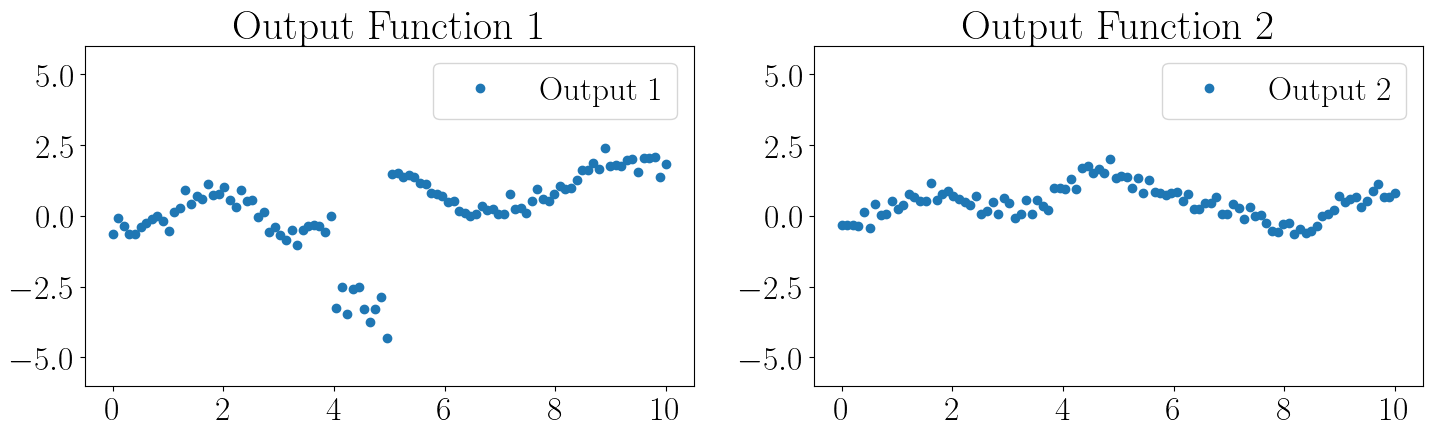

In [7]:
np.random.seed(42)
N = 100
D = 2

X = np.linspace(0.0, 10, N)
Y = sample_icm_rbf(X, lengthscale=1, noise_variance=0.05, random_state=41)

# Outliers
outlier_range = np.where((X >= 4) & (X <= 5))[0]
outlier_indices = np.random.choice(outlier_range, int(10), replace=False)
Y[outlier_indices, 0] = np.random.normal(loc=-3, scale=0.5, size=outlier_indices.shape[0])

# Plotting
fig, axs = plt.subplots(1, 2, figsize=(15, 5))

for i in range(2):
    axs[i].plot(X.flatten(), Y[:, i], 'o', label=f'Output {i+1}')
    axs[i].set_title(f"Output Function {i+1}")
    axs[i].set_ylim([-6, 6])
    axs[i].legend()

plt.tight_layout()
plt.show()

Optimized length_scale: 0.5877, noise: 0.174234
Optimized A: [[ 1.51483353  0.07615647]
 [-0.16392616  0.54370291]]
Optimized B: 
[[ 2.30052043 -0.20691436]
 [-0.20691436  0.32248464]]


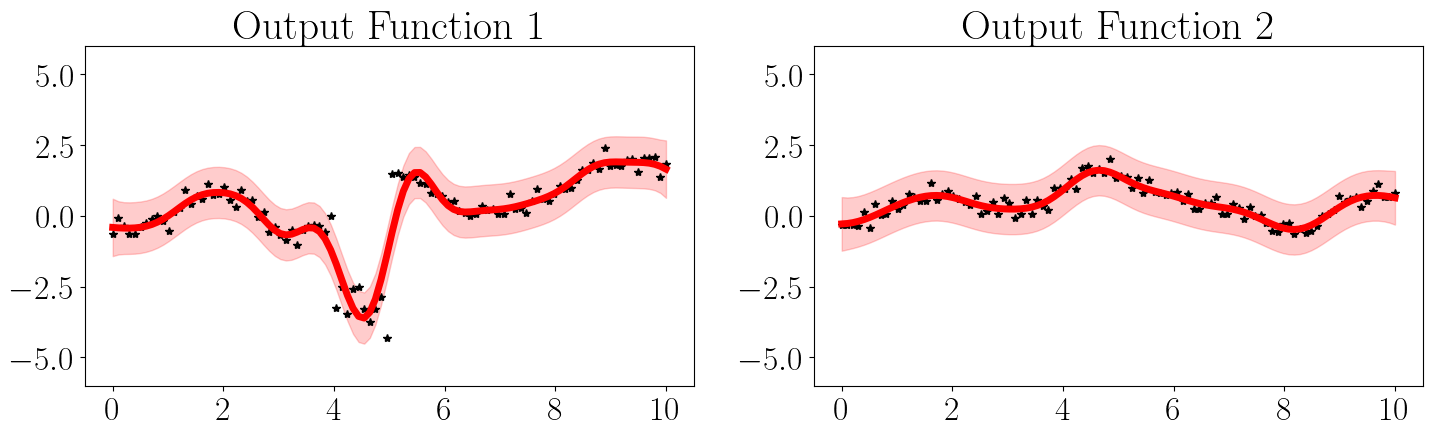

In [10]:
# Instantiate and train
# mogp = MOGPRegressor(mean = 0, length_scale=0.1, noise = noise, A=A)
mogp = MOGPRegressor_NC(mean = 0, length_scale=0.1, noise = 0.04, A=np.array([[1, 0.7], [0.7, 1]]))
mogp.fit(X.reshape(-1,1), Y)

# Optimize hyperparameters
mogp.optimize_hyperparameters()
# mogp.optimize_loo_cv(print_opt_param=True, print_iter_param=True)

# Predict on test points
x_test = np.linspace(0, 10, 100).reshape(-1, 1)
mu, var = mogp.predict(x_test)
std = np.sqrt(var + mogp.noise)

# Plotting
fig, axs = plt.subplots(1, 2, figsize=(15, 5))

for i in range(2):
    axs[i].plot(X.flatten(), Y[:, i], 'k*', label=f'Observed Data')
    axs[i].plot(x_test.flatten(), mu[:, i], 'r-', label=f'Predicted Mean')
    axs[i].fill_between(x_test.flatten(), mu[:, i] - 2*std[:, i], mu[:, i] + 2*std[:, i], color='r', alpha=0.2, label=f'±2 Std. Dev.')

    axs[i].set_title(f"Output Function {i+1}")
    axs[i].set_ylim([-6, 6])
    # axs[i].legend()

plt.tight_layout()
plt.show()

# Energy Efficiency Dataset

In [146]:
import pandas as pd

# URL of the dataset
url = 'https://archive.ics.uci.edu/ml/machine-learning-databases/00242/ENB2012_data.xlsx'

# Read Excel file directly from the URL
df = pd.read_excel(url)

# Extract covariates X (columns X1 to X8)
X = df.loc[:, 'X1':'X8'].to_numpy()

# Extract target variables Y (columns Y1 and Y2)
Y = df.loc[:, ['Y1', 'Y2']].to_numpy()

# Split data into train and test sets (default test size = 25%)
X_train, X_test, Y_train, Y_test = train_test_split(
    X, Y, test_size=0.25, random_state=42
)

## No outliers

In [82]:
scaler_X = StandardScaler()
X_train_scaled = scaler_X.fit_transform(X_train)
X_test_scaled = scaler_X.transform(X_test)

scaler_Y = StandardScaler()
Y_train_scaled = scaler_Y.fit_transform(Y_train)
Y_test_scaled = scaler_Y.transform(Y_test)

print("X_train shape:", X_train_scaled.shape)
print("X_test shape:", X_test_scaled.shape)
print("Y_train shape:", Y_train_scaled.shape)
print("Y_test shape:", Y_test_scaled.shape)

X_train shape: (576, 8)
X_test shape: (192, 8)
Y_train shape: (576, 2)
Y_test shape: (192, 2)


In [83]:
initial_A = generate_A(d = 2, r = 2)

# Measure total time
start_total = time.time()

mogp = MOGPRegressor_NC(mean=0, length_scale=1.67, noise=0.04, A=initial_A)
mogp.fit(X_train_scaled, Y_train_scaled)

# Optimize hyperparameters
mogp.optimize_hyperparameters()
optim_lengthscale = mogp.length_scale
optim_noise = mogp.noise
optim_A = mogp.A
optim_B = optim_A @ optim_A.T

# Measure prediction time
start_pred = time.time()
mu_mogp, var_mogp = mogp.predict(X_test_scaled)
std_mogp = np.sqrt(var_mogp + mogp.noise)
end_pred = time.time()

end_total = time.time()

print(f"Total runtime: {end_total - start_total:.4f} seconds")
print(f"Prediction runtime: {end_pred - start_pred:.4f} seconds")

Optimized length_scale: 1.6632, noise: 0.005985
Optimized A: [[0.76628949 1.06124471]
 [1.38576648 0.95103837]]
Optimized B: 
[[1.71343992 2.07118273]
 [2.07118273 2.82482272]]
Total runtime: 20.8605 seconds
Prediction runtime: 0.9640 seconds


In [ ]:
# Measure total time
start_total = time.time()
morcgp = MORCGPRegressor_NC_fixed_weights(mean = 0, length_scale=optim_lengthscale, noise = optim_noise, A=optim_A)
predictive_mean, predictive_variances = morcgp.fit(X_train_scaled, Y_train_scaled, B_weighted=optim_B, noise_weighted=optim_noise)

predictive_mean, predictive_variances = morcgp.optimize_loo_cv(weighted=True, print_opt_param = False, print_iter_param=False, update_weights=True)

start_pred = time.time()
mu_morcgp, var_morcgp = morcgp.predict(X_test_scaled)
std_morcgp = np.sqrt(var_morcgp + morcgp.noise)

end_pred = time.time()
end_total = time.time()
print(f"Total runtime: {end_total - start_total:.4f} seconds")
print(f"Prediction runtime: {end_pred - start_pred:.4f} seconds")

[[0.74211088]
 [0.79867192]
 [0.95945957]
 ...
 [0.88537184]
 [0.95863195]
 [0.90189245]]
[[0.56348823]
 [0.63702194]
 [0.56425967]
 ...
 [0.89505596]
 [0.96219326]
 [0.93981978]]
Total runtime: 46.4197 seconds
Prediction runtime: 0.9292 seconds


In [25]:
rmse_mogp = calculate_rmse(Y_test_scaled, mu_mogp)
rmse_morcgp = calculate_rmse(Y_test_scaled, mu_morcgp)

print("RMSE MOGP:", rmse_mogp)
print("RMSE MORCGP:", rmse_morcgp)

nlpd_mogp = nlpd(Y_test_scaled, mu_mogp, std_mogp**2)
nlpd_morcgp = nlpd(Y_test_scaled, mu_morcgp, std_morcgp**2)

print("NLPD MOGP:", nlpd_mogp)
print("NLPD MORCGP:", nlpd_morcgp)

RMSE MOGP: 0.11624272893514793
RMSE MORCGP: 0.1207940026584556
NLPD MOGP: -0.8026848692113911
NLPD MORCGP: -0.8373628964730143


## Uniform outliers

In [26]:
scaler_X = StandardScaler()
X_train_scaled = scaler_X.fit_transform(X_train)
X_test_scaled = scaler_X.transform(X_test)

scaler_Y = StandardScaler()
Y_train_scaled = scaler_Y.fit_transform(Y_train)
Y_test_scaled = scaler_Y.transform(Y_test)

Y_train_scaled = uniform_outliers_c1(Y=Y_train_scaled, percent_outliers=0.1, start=2, end=3)

print("X_train shape:", X_train_scaled.shape)
print("X_test shape:", X_test_scaled.shape)
print("Y_train shape:", Y_train_scaled.shape)
print("Y_test shape:", Y_test_scaled.shape)

X_train shape: (576, 8)
X_test shape: (192, 8)
Y_train shape: (576, 2)
Y_test shape: (192, 2)


In [27]:
initial_A = generate_A(d = 2, r = 2)
start_total = time.time()
mogp = MOGPRegressor_NC(mean = 0, length_scale=1.67, noise = 0.04, A=initial_A)
mogp.fit(X_train_scaled, Y_train_scaled)

print('Fitted data')

# Optimize hyperparameters
mogp.optimize_hyperparameters()
optim_lengthscale = mogp.length_scale
optim_noise = mogp.noise
optim_A = mogp.A
optim_B = optim_A @ optim_A.T

print('Optimized hyperparameters')

# Predict on test points
start_pred = time.time()
mu_mogp, var_mogp = mogp.predict(X_test_scaled)
std_mogp = np.sqrt(var_mogp + mogp.noise)

end_pred = time.time()
end_total = time.time()
print(f"Total runtime: {end_total - start_total:.4f} seconds")
print(f"Prediction runtime: {end_pred - start_pred:.4f} seconds")

Fitted data
Optimized length_scale: 2.6427, noise: 0.350704
Optimized A: [[0.89088083 0.68268895]
 [0.54916844 0.67010837]]
Optimized B: 
[[1.25973285 0.94671921]
 [0.94671921 0.7506312 ]]
Optimized hyperparameters
Total runtime: 21.8563 seconds
Prediction runtime: 1.2028 seconds


In [28]:
cov_matrix = np.cov(Y_train_scaled, rowvar=False)
print(cov_matrix)

start_total = time.time()
morcgp = MORCGPRegressor_NC_fixed_weights(mean = 0, length_scale=optim_lengthscale, noise = optim_noise, A=optim_A)
initial_predictive_mean, initial_predictive_variances = morcgp.fit(X_train_scaled, Y_train_scaled, B_weighted=optim_B, noise_weighted=optim_noise)
# print(predictive_mean)
# print(predictive_variances)
# print('Fitted data')

# print(morcgp.loo_cv(length_scale=optim_lengthscale, noise=optim_noise, A=optim_A, weighted=True))
predictive_mean, predictive_variances = morcgp.optimize_loo_cv(weighted=True, print_opt_param = True, print_iter_param=False, update_weights=True)


start_pred = time.time()
mu_morcgp, var_morcgp = morcgp.predict(X_test_scaled)
std_morcgp = np.sqrt(var_morcgp + morcgp.noise)

end_pred = time.time()
end_total = time.time()
print(f"Total runtime: {end_total - start_total:.4f} seconds")
print(f"Prediction runtime: {end_pred - start_pred:.4f} seconds")

[[1.73626024 1.03424983]
 [1.03424983 1.00173913]]
[[0.33250003]
 [0.97648431]
 [0.98950258]
 ...
 [0.88007276]
 [0.95527635]
 [0.98351215]]
Optimized length_scale: 1.2418, noise: 0.107659
Optimized A: [[0.8965471  0.97266993]
 [0.84003389 0.49429554]]
Optimized B: 
[[1.7498835  1.23391636]
 [1.23391636 0.94998502]]
[[0.29332207]
 [0.97468594]
 [0.64654506]
 ...
 [0.84331985]
 [0.93900015]
 [0.98537457]]
Total runtime: 37.5016 seconds
Prediction runtime: 1.0284 seconds


In [29]:
rmse_mogp = calculate_rmse(Y_test_scaled, mu_mogp)
rmse_morcgp = calculate_rmse(Y_test_scaled, mu_morcgp)

print("RMSE MOGP:", rmse_mogp)
print("RMSE MORCGP:", rmse_morcgp)

nlpd_mogp = nlpd(Y_test_scaled, mu_mogp, std_mogp**2)
nlpd_morcgp = nlpd(Y_test_scaled, mu_morcgp, std_morcgp**2)

print("NLPD MOGP:", nlpd_mogp)
print("NLPD MORCGP:", nlpd_morcgp)

RMSE MOGP: 0.3015691517400871
RMSE MORCGP: 0.20311131413846453
NLPD MOGP: 0.548853588181402
NLPD MORCGP: 0.17492606253257112


In [49]:
print('mu_mogp', mu_mogp.reshape(-1)[:6])
print('mu_morcgp', mu_morcgp.reshape(-1)[:6])
print('true test', Y_test_scaled.reshape(-1)[:6])
print('true train', Y_train_scaled.reshape(-1)[:6])
print('init_pred_mean:', initial_predictive_mean.reshape(-1)[:6])
print('init_pred_var:', initial_predictive_variances.reshape(-1)[:6])
print('pred_mean:', predictive_mean.reshape(-1)[:6])
print('pred_var:', predictive_variances.reshape(-1)[:6])

mu_mogp [ 1.62259641 -0.32332069 -2.48024602 -0.78413153  1.38783968  0.79891153]
mu_morcgp [ 0.76994442 -0.29475586 -2.01620726 -0.76118056  1.22478069  0.76062359]
true test [-0.57017686 -0.80214681 -0.89977479 -0.85618524  1.06283109  0.8804617 ]
true train [ 1.30453624  1.35621184 -0.93273458 -0.86995975 -1.10252746 -1.0670411 ]
init_pred_mean: [ 1.37334308  0.04836846 -0.8809488  -0.03458312 -1.08051962 -0.04087856]
init_pred_var: [10.25955188  0.37468629 10.25955188  0.37468629 10.25955188  0.37468629]
pred_mean: [ 1.62781477  0.02931946 -1.04418298 -0.02096321 -1.280733   -0.02477931]
pred_var: [10.35084904  0.19283859 10.35084904  0.19283859 10.35084904  0.19283859]


In [ ]:
def extract_and_remove_dth(matrix, d):
    row_without_diag = np.delete(matrix[d, :], d)
    diag_elem = matrix[d, d]
    reduced_matrix = np.delete(np.delete(matrix, d, axis=0), d, axis=1)

    return row_without_diag, diag_elem, reduced_matrix

def cross_channel_predictive(Y_train, mean, B, noise):
        N, D = Y_train.shape
        if np.isscalar(noise):
            noise_matrix = noise * np.eye(D)
        else:
            noise_matrix = np.diag(noise.flatten())
        B_noise = B + noise_matrix
        predictive_means, predictive_variances = np.zeros(Y_train.shape), np.zeros(Y_train.shape)
        
        for i in range(N):
            row = Y_train[i, :]
            for d in range(D):
                if np.isnan(row[d]):
                    predictive_means[i, d] = np.nan
                    predictive_variances[i, d] = np.nan
                else:
                    obs_other = np.delete(row, d)
                    B_d_other, B_dd, B_other_other = extract_and_remove_dth(B_noise, d)

                    # Mask to filter out NaNs
                    mask = ~np.isnan(obs_other)
                    if not np.any(mask):
                        # If all values in obs_other are NaN
                        conditional_mean = mean
                        conditional_variance = B_dd
                    else:
                        B_d_other_masked = B_d_other[mask]
                        B_other_other_masked = B_other_other[np.ix_(mask, mask)] + 1e-3 * np.eye(len(B_other_other[np.ix_(mask, mask)]))
                        obs_other_masked = obs_other[mask]

                        conditional_mean = (
                            mean +
                            B_d_other_masked.reshape(1, -1) @
                            np.linalg.inv(B_other_other_masked) @
                            (obs_other_masked.reshape(-1, 1) - mean)
                        ).item()
                        conditional_variance = (
                            B_dd -
                            B_d_other_masked.reshape(1, -1) @
                            np.linalg.inv(B_other_other_masked) @
                            B_d_other_masked.reshape(-1, 1)
                        ).item()

                    predictive_means[i, d] = conditional_mean
                    predictive_variances[i, d] = conditional_variance

        return predictive_means, predictive_variances



In [30]:
print(Y_train_scaled)

[[ 1.30453624  1.35621184]
 [-0.93273458 -0.86995975]
 [-1.10252746 -2.47057727]
 [ 1.64711834  2.04811572]
 [-1.24269693  0.26272822]
 [ 0.34770345  0.19385571]
 [ 1.85886004  2.16149048]
 [ 0.6822953   0.88787874]
 [ 0.58970562 -1.14439023]
 [-0.75495146 -0.76824034]
 [-0.58216224 -0.77671696]
 [-1.96529166 -2.24986993]
 [ 1.00190541  1.00443223]
 [ 0.33072416  0.38881791]
 [ 1.04784937  0.81052961]
 [-0.72498801 -0.70784444]
 [-0.50325849 -0.7703595 ]
 [-0.92374555 -0.93671311]
 [ 1.79893315  1.37104592]
 [-0.68803309 -0.70466571]
 [-0.91975042 -1.0808156 ]
 [ 1.34748385  1.00337265]
 [-2.38373946 -1.04902829]
 [ 0.29876315  0.20551106]
 [ 0.29876315  0.17054501]
 [-0.93872727 -0.98121535]
 [-0.77105604  0.14907766]
 [-1.13948238 -1.0945901 ]
 [ 1.05583962  1.00973011]
 [-0.97368463 -0.9833345 ]
 [ 1.04884815  0.88575959]
 [-0.33346561 -0.20984318]
 [-0.51224752 -1.81835806]
 [ 1.43238029  0.11405331]
 [-2.61930541 -1.0575049 ]
 [ 1.78295264  1.41342901]
 [ 3.33365262  2.54426188]
 

In [29]:
pred_mean, pred_var = cross_channel_predictive(Y_train_scaled, mean=0, B=optim_B, noise=optim_noise)
print(pred_mean)

[[ 1.20958243  1.14217305]
 [-0.7759024  -0.816646  ]
 [-2.20346612 -0.96530637]
 [ 1.82667981  1.44211722]
 [ 0.23432286 -1.08803029]
 [ 0.17289663  0.30442812]
 [ 1.92779683  1.62750545]
 [ 0.79188405  0.5973765 ]
 [-1.02066231  0.51631058]
 [-0.68518058 -0.66098984]
 [-0.69274073 -0.50970605]
 [-2.00662098 -1.72069054]
 [ 0.89583613  0.8772078 ]
 [ 0.34678012  0.28956208]
 [ 0.72289766  0.91743354]
 [-0.6313145  -0.63475566]
 [-0.68707062 -0.4406227 ]
 [-0.83543859 -0.80877574]
 [ 1.22281269  1.57503708]
 [-0.62847944 -0.60240017]
 [-0.96396117 -0.80527785]
 [ 0.89489112  1.17977538]
 [-0.9356106  -2.08705813]
 [ 0.18329184  0.26157895]
 [ 0.15210622  0.26157895]
 [-0.87512939 -0.82189284]
 [ 0.13295985 -0.67509004]
 [-0.97624642 -0.99766187]
 [ 0.90056123  0.92442933]
 [-0.87701943 -0.85249938]
 [ 0.78999401  0.91830802]
 [-0.18715559 -0.29196233]
 [-1.62176283 -0.44849296]
 [ 0.10172222  1.25410557]
 [-0.94317076 -2.29330543]
 [ 1.26061345  1.56104552]
 [ 2.26918418  2.91874465]
 

## Asymmetric outliers

In [87]:
scaler_X = StandardScaler()
X_train_scaled = scaler_X.fit_transform(X_train)
X_test_scaled = scaler_X.transform(X_test)

scaler_Y = StandardScaler()
Y_train_scaled = scaler_Y.fit_transform(Y_train)
Y_test_scaled = scaler_Y.transform(Y_test)

Y_train_scaled = asymmetric_outliers_c1(Y=Y_train_scaled, percent_outliers=0.1, start=2, end=3)

print("X_train shape:", X_train_scaled.shape)
print("X_test shape:", X_test_scaled.shape)
print("Y_train shape:", Y_train_scaled.shape)
print("Y_test shape:", Y_test_scaled.shape)

X_train shape: (576, 8)
X_test shape: (192, 8)
Y_train shape: (576, 2)
Y_test shape: (192, 2)


In [89]:
initial_A = generate_A(d = 2, r = 2)
start_total = time.time()
mogp = MOGPRegressor_NC(mean = 0, length_scale=1.67, noise = 0.04, A=initial_A)
mogp.fit(X_train_scaled, Y_train_scaled)

print('Fitted data')

# Optimize hyperparameters
mogp.optimize_hyperparameters()
optim_lengthscale = mogp.length_scale
optim_noise = mogp.noise
optim_A = mogp.A
optim_B = optim_A @ optim_A.T

print('Optimized hyperparameters')

# Predict on test points
start_pred = time.time()
mu_mogp, var_mogp = mogp.predict(X_test_scaled)
std_mogp = np.sqrt(var_mogp + mogp.noise)
end_pred = time.time()
end_total = time.time()
print(f"Total runtime: {end_total - start_total:.4f} seconds")
print(f"Prediction runtime: {end_pred - start_pred:.4f} seconds")

Fitted data
Optimized length_scale: 3.4083, noise: 0.350650
Optimized A: [[0.67972523 0.92749955]
 [0.74125592 0.73128163]]
Optimized B: 
[[1.32228179 1.18211373]
 [1.18211373 1.08423316]]
Optimized hyperparameters
Total runtime: 22.1641 seconds
Prediction runtime: 1.1468 seconds


In [90]:
cov_matrix = np.cov(Y_train_scaled, rowvar=False)
print(cov_matrix)

start_total = time.time()
morcgp = MORCGPRegressor_NC_fixed_weights(mean = 0, length_scale=optim_lengthscale, noise = optim_noise, A=optim_A)
initial_predictive_mean, initial_predictive_variances = morcgp.fit(X_train_scaled, Y_train_scaled, B_weighted=optim_B, noise_weighted=optim_noise)
# print(predictive_mean)
# print(predictive_variances)
# print('Fitted data')

# print(morcgp.loo_cv(length_scale=optim_lengthscale, noise=optim_noise, A=optim_A, weighted=True))
predictive_mean, predictive_variances = morcgp.optimize_loo_cv(weighted=True, print_opt_param = True, print_iter_param=False, update_weights=True)

print('Optimized hyperparameters')

start_pred = time.time()

mu_morcgp, var_morcgp = morcgp.predict(X_test_scaled)
std_morcgp = np.sqrt(var_morcgp + morcgp.noise)

end_pred = time.time()
end_total = time.time()
print(f"Total runtime: {end_total - start_total:.4f} seconds")
print(f"Prediction runtime: {end_pred - start_pred:.4f} seconds")

[[1.57962854 0.98738443]
 [0.98738443 1.00173913]]
Optimized length_scale: 0.7557, noise: 0.079800
Optimized A: [[0.89240807 1.12601841]
 [0.90342972 0.92392722]]
Optimized B: 
[[2.06430963 1.84658704]
 [1.84658704 1.66982678]]
Optimized hyperparameters
Total runtime: 98.0887 seconds
Prediction runtime: 0.9122 seconds


In [91]:
rmse_mogp = calculate_rmse(Y_test_scaled, mu_mogp)
rmse_morcgp = calculate_rmse(Y_test_scaled, mu_morcgp)

print("RMSE MOGP:", rmse_mogp)
print("RMSE MORCGP:", rmse_morcgp)

nlpd_mogp = nlpd(Y_test_scaled, mu_mogp, std_mogp**2)
nlpd_morcgp = nlpd(Y_test_scaled, mu_morcgp, std_morcgp**2)

print("NLPD MOGP:", nlpd_mogp)
print("NLPD MORCGP:", nlpd_morcgp)

RMSE MOGP: 0.3164642994423512
RMSE MORCGP: 0.22076387249926974
NLPD MOGP: 0.5537475164815021
NLPD MORCGP: 0.5553438314265979


## Focussed outliers

In [171]:
scaler_X = StandardScaler()
X_train_scaled = scaler_X.fit_transform(X_train)
X_test_scaled = scaler_X.transform(X_test)

scaler_Y = StandardScaler()
Y_train_scaled = scaler_Y.fit_transform(Y_train)
Y_test_scaled = scaler_Y.transform(Y_test)

X_train_scaled, Y_train_scaled = focused_outliers(X=X_train_scaled, Y=Y_train_scaled, percent_outliers=0.1, y_value=4)

print("X_train shape:", X_train_scaled.shape)
print("X_test shape:", X_test_scaled.shape)
print("Y_train shape:", Y_train_scaled.shape)
print("Y_test shape:", Y_test_scaled.shape)

X_train shape: (576, 8)
X_test shape: (192, 8)
Y_train shape: (576, 2)
Y_test shape: (192, 2)


In [172]:
print(Y_train_scaled[22, 0].reshape(-1))
print(X_train_scaled[22, :].reshape(-1)[:6])
print(Y_train_scaled[25, 0].reshape(-1))
print(X_train_scaled[25, :].reshape(-1)[:6])

[-1.60025085]
[-0.20750542  0.13997502 -1.70692896  0.95559713 -0.98278701 -1.37107134]
[0.77638774]
[ 0.93081004 -0.97210237 -0.56567408 -0.68501076  1.01751447  1.34280183]


In [173]:
initial_A = generate_A(d = 2, r = 2)
start_total = time.time()
mogp = MOGPRegressor_NC(mean = 0, length_scale=1.67, noise = 0.04, A=initial_A)
mogp.fit(X_train_scaled, Y_train_scaled)

print('Fitted data')

# Optimize hyperparameters
mogp.optimize_hyperparameters()
optim_lengthscale = mogp.length_scale
optim_noise = mogp.noise
optim_A = mogp.A
optim_B = optim_A @ optim_A.T

print('Optimized hyperparameters')

# Predict on test points
start_pred = time.time()
mu_mogp, var_mogp = mogp.predict(X_test_scaled)
std_mogp = np.sqrt(var_mogp + mogp.noise)
end_pred = time.time()
end_total = time.time()
print(f"Total runtime: {end_total - start_total:.4f} seconds")
print(f"Prediction runtime: {end_pred - start_pred:.4f} seconds")

Fitted data
Optimized length_scale: 8.4065, noise: 0.065741
Optimized A: [[29.44205999 35.6506892 ]
 [37.63733649 30.22173797]]
Optimized B: 
[[2137.80653631 2185.546506  ]
 [2185.546506   2329.92254405]]
Optimized hyperparameters
Total runtime: 139.5186 seconds
Prediction runtime: 0.8170 seconds


In [169]:
cov_matrix = np.cov(Y_train_scaled, rowvar=False)
print(cov_matrix)

start_total = time.time()
morcgp = MORCGPRegressor_NC_fixed_weights(mean = 0, length_scale=optim_lengthscale, noise = optim_noise, A=optim_A)
initial_predictive_mean, initial_predictive_variances = morcgp.fit(X_train_scaled, Y_train_scaled, B_weighted=optim_B, noise_weighted=optim_noise)
# print(predictive_mean)
# print(predictive_variances)
# print('Fitted data')

# print(morcgp.loo_cv(length_scale=optim_lengthscale, noise=optim_noise, A=optim_A, weighted=True))
predictive_mean, predictive_variances = morcgp.optimize_loo_cv(weighted=True, print_opt_param = True, print_iter_param=False, update_weights=True)

print('Optimized hyperparameters')

start_pred = time.time()

mu_morcgp, var_morcgp = morcgp.predict(X_test_scaled)
std_morcgp = np.sqrt(var_morcgp + morcgp.noise)

end_pred = time.time()
end_total = time.time()
print(f"Total runtime: {end_total - start_total:.4f} seconds")
print(f"Prediction runtime: {end_pred - start_pred:.4f} seconds")

[[2.3349714  0.90094048]
 [0.90094048 1.00173913]]
Optimized length_scale: 5.2255, noise: 0.056762
Optimized A: [[37.84252851 27.96016473]
 [27.75179655 29.89794963]]
Optimized B: 
[[2213.8277762  1886.14974913]
 [1886.14974913 1664.04960399]]
Optimized hyperparameters
Total runtime: 39.6866 seconds
Prediction runtime: 0.2705 seconds


In [170]:
rmse_mogp = calculate_rmse(Y_test_scaled, mu_mogp)
rmse_morcgp = calculate_rmse(Y_test_scaled, mu_morcgp)

print("RMSE MOGP:", rmse_mogp)
print("RMSE MORCGP:", rmse_morcgp)

nlpd_mogp = nlpd(Y_test_scaled, mu_mogp, std_mogp**2)
nlpd_morcgp = nlpd(Y_test_scaled, mu_morcgp, std_morcgp**2)

print("NLPD MOGP:", nlpd_mogp)
print("NLPD MORCGP:", nlpd_morcgp)

RMSE MOGP: 0.1655266583690882
RMSE MORCGP: 0.1286494995734203
NLPD MOGP: -0.13376827592326565
NLPD MORCGP: -0.2766182227614696


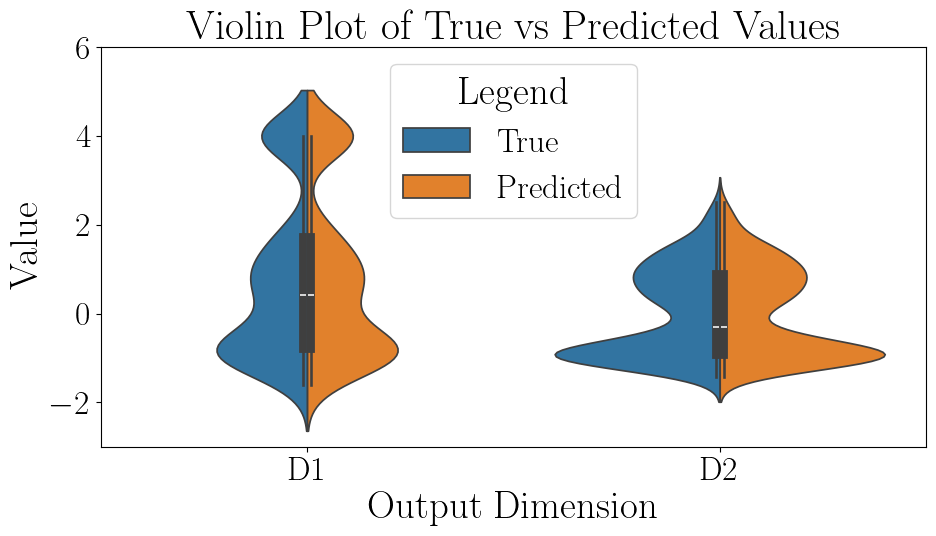

In [165]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# Assuming mean_pred_np and Y_multi_test are numpy arrays with shape (N_test, D)
# Create a long-form DataFrame for seaborn
import pandas as pd

# Reshape into long-form format
N_test, D = Y_train_scaled.shape
data = {
    "Value": np.concatenate([Y_train_scaled.flatten(), Y_train_scaled.flatten()]),
    "Type": ["True"] * (N_test * D) + ["Predicted"] * (N_test * D),
    "Dimension": [f"D{i+1}" for i in range(D)] * N_test * 2
}

df = pd.DataFrame(data)

# Violin plot
plt.figure(figsize=(10, 6))
sns.violinplot(x="Dimension", y="Value", hue="Type", data=df, split=True)
plt.title("Violin Plot of True vs Predicted Values")
plt.ylabel("Value")
plt.xlabel("Output Dimension")
plt.legend(title="Legend")
plt.tight_layout()
plt.ylim(-3,6)
plt.show()


## Joint outliers

In [110]:
scaler_X = StandardScaler()
X_train_scaled = scaler_X.fit_transform(X_train)
X_test_scaled = scaler_X.transform(X_test)

scaler_Y = StandardScaler()
Y_train_scaled = scaler_Y.fit_transform(Y_train)
Y_test_scaled = scaler_Y.transform(Y_test)

Y_train_scaled = joint_outliers_opposite_sign(Y=Y_train_scaled, percent_outliers=0.05, start=2, end=3)

print("X_train shape:", X_train_scaled.shape)
print("X_test shape:", X_test_scaled.shape)
print("Y_train shape:", Y_train_scaled.shape)
print("Y_test shape:", Y_test_scaled.shape)

X_train shape: (576, 8)
X_test shape: (192, 8)
Y_train shape: (576, 2)
Y_test shape: (192, 2)


In [111]:
initial_A = generate_A(d = 2, r = 2)
start_total = time.time()
mogp = MOGPRegressor_NC(mean = 0, length_scale=1.67, noise = 0.04, A=initial_A)
mogp.fit(X_train_scaled, Y_train_scaled)

print('Fitted data')

# Optimize hyperparameters
mogp.optimize_hyperparameters()
optim_lengthscale = mogp.length_scale
optim_noise = mogp.noise
optim_A = mogp.A
optim_B = optim_A @ optim_A.T

print('Optimized hyperparameters')

# Predict on test points
start_pred = time.time()
mu_mogp, var_mogp = mogp.predict(X_test_scaled)
std_mogp = np.sqrt(var_mogp + mogp.noise)
end_pred = time.time()
end_total = time.time()
print(f"Total runtime: {end_total - start_total:.4f} seconds")
print(f"Prediction runtime: {end_pred - start_pred:.4f} seconds")

Fitted data
Optimized length_scale: 0.5502, noise: 0.002826
Optimized A: [[0.56911435 0.81527438]
 [0.74188854 0.68309576]]
Optimized B: 
[[0.98856346 0.97912988]
 [0.97912988 1.01701842]]
Optimized hyperparameters
Total runtime: 25.5016 seconds
Prediction runtime: 0.8871 seconds


In [112]:
cov_matrix = np.cov(Y_train_scaled, rowvar=False)
print(cov_matrix)

start_total = time.time()
morcgp = MORCGPRegressor_NC_fixed_weights(mean = 0, length_scale=optim_lengthscale, noise = optim_noise, A=optim_A)
initial_predictive_mean, initial_predictive_variances = morcgp.fit(X_train_scaled, Y_train_scaled, B_weighted=optim_B, noise_weighted=optim_noise)
# print(predictive_mean)
# print(predictive_variances)
# print('Fitted data')

# print(morcgp.loo_cv(length_scale=optim_lengthscale, noise=optim_noise, A=optim_A, weighted=True))
predictive_mean, predictive_variances = morcgp.optimize_loo_cv(weighted=True, print_opt_param = True, print_iter_param=False, update_weights=True)

print('Optimized hyperparameters')

start_pred = time.time()

mu_morcgp, var_morcgp = morcgp.predict(X_test_scaled)
std_morcgp = np.sqrt(var_morcgp + morcgp.noise)

end_pred = time.time()
end_total = time.time()
print(f"Total runtime: {end_total - start_total:.4f} seconds")
print(f"Prediction runtime: {end_pred - start_pred:.4f} seconds")

[[1.07949487 1.05107625]
 [1.05107625 1.07819467]]
Optimized length_scale: 0.5911, noise: 0.002781
Optimized A: [[0.70016937 0.70177376]
 [0.61414668 0.79707754]]
Optimized B: 
[[0.98272356 0.9893748 ]
 [0.9893748  1.01250876]]
Optimized hyperparameters
Total runtime: 50.2003 seconds
Prediction runtime: 0.7706 seconds


In [113]:
rmse_mogp = calculate_rmse(Y_test_scaled, mu_mogp)
rmse_morcgp = calculate_rmse(Y_test_scaled, mu_morcgp)

print("RMSE MOGP:", rmse_mogp)
print("RMSE MORCGP:", rmse_morcgp)

nlpd_mogp = nlpd(Y_test_scaled, mu_mogp, std_mogp**2)
nlpd_morcgp = nlpd(Y_test_scaled, mu_morcgp, std_morcgp**2)

print("NLPD MOGP:", nlpd_mogp)
print("NLPD MORCGP:", nlpd_morcgp)

RMSE MOGP: 0.5991505222017118
RMSE MORCGP: 0.6234725516417132
NLPD MOGP: 0.9713574148134737
NLPD MORCGP: 1.051248490115622


# SARCOS dataset

In [15]:
import scipy.io
import numpy as np

# Load the .mat file
data = scipy.io.loadmat('sarcos_inv.mat')

# The key you want is usually 'sarcos_inv'
dataset = data['sarcos_inv']  # Shape should be (n_samples, 21)

# X: first 21 - 7 = 14 columns (joint positions, velocities, accelerations)
X_full = dataset[:, 0:21]

# Y: last 7 columns (joint torques)
Y_full = dataset[:, 22:24]



In [16]:
# Number of samples to draw
n_samples = 1000

# Randomly sample 1000 indices without replacement
np.random.seed(42)  # for reproducibility
indices = np.random.choice(dataset.shape[0], size=n_samples, replace=False)

# Subset the data
X_sample = X_full[indices]
Y_sample = Y_full[indices]

# Split into train and test
X_train = X_sample[:500]
Y_train = Y_sample[:500]
X_test = X_sample[500:]
Y_test = Y_sample[500:]

# Check shapes
print(X_train.shape, Y_train.shape)
print(X_test.shape, Y_test.shape)

(500, 21) (500, 2)
(500, 21) (500, 2)


# Student performance dataset

In [ ]:
from ucimlrepo import fetch_ucirepo 
  
# fetch dataset 
student_performance = fetch_ucirepo(id=320) 
  
# data (as pandas dataframes) 
X = student_performance.data.features
Y = student_performance.data.targets
  
print(X.shape)
print(Y.shape)


(649, 30)
(649, 3)
<class 'pandas.core.frame.DataFrame'>


In [61]:
for col in X.select_dtypes(include='object').columns:
    X.loc[:, col] = X[col].astype('category').cat.codes

X_numeric = X.astype(float)


In [25]:
print(student_performance.variables) 

          name     role         type      demographic  \
0       school  Feature  Categorical             None   
1          sex  Feature       Binary              Sex   
2          age  Feature      Integer              Age   
3      address  Feature  Categorical             None   
4      famsize  Feature  Categorical            Other   
5      Pstatus  Feature  Categorical            Other   
6         Medu  Feature      Integer  Education Level   
7         Fedu  Feature      Integer  Education Level   
8         Mjob  Feature  Categorical       Occupation   
9         Fjob  Feature  Categorical       Occupation   
10      reason  Feature  Categorical             None   
11    guardian  Feature  Categorical             None   
12  traveltime  Feature      Integer             None   
13   studytime  Feature      Integer             None   
14    failures  Feature      Integer             None   
15   schoolsup  Feature       Binary             None   
16      famsup  Feature       B

In [ ]:
from sklearn.model_selection import train_test_split

# Assuming X_numeric is your feature matrix and Y is your target vector
X_train, X_test, y_train, y_test = train_test_split(X_numeric, Y, test_size=0.25, random_state=42)



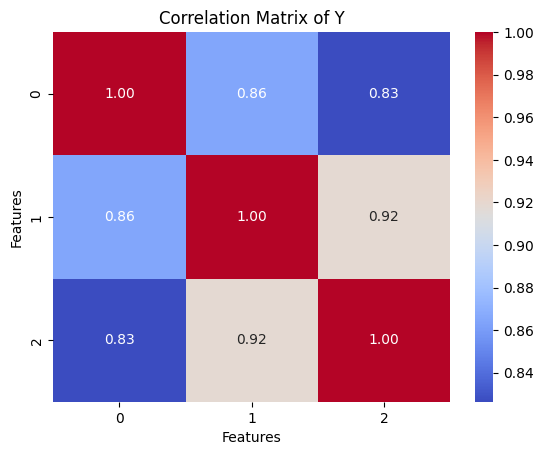

In [26]:
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

# Example: assume Y is your NumPy array with shape (n_samples, n_features)
# Y = np.random.rand(100, 5)  # Uncomment to test

# Compute correlation matrix
corr_matrix = np.corrcoef(Y, rowvar=False)

# Plot heatmap
sns.heatmap(corr_matrix, annot=True, cmap='coolwarm', fmt=".2f")
plt.title("Correlation Matrix of Y")
plt.xlabel("Features")
plt.ylabel("Features")
plt.show()


In [64]:
# Initialize scalers
scaler_X = StandardScaler()
X_train_scaled = scaler_X.fit_transform(X_train)
X_test_scaled = scaler_X.transform(X_test)

scaler_Y = StandardScaler()
Y_train_scaled = scaler_Y.fit_transform(y_train)
Y_test_scaled = scaler_Y.transform(y_test)

In [65]:
initial_A = generate_A(d = 3, r = 2)

# Measure total time
start_total = time.time()

mogp = MOGPRegressor_NC(mean=0, length_scale=1.67, noise=0.04, A=initial_A)
mogp.fit(X_train_scaled, Y_train_scaled)

# Optimize hyperparameters
mogp.optimize_hyperparameters()
optim_lengthscale = mogp.length_scale
optim_noise = mogp.noise
optim_A = mogp.A
optim_B = optim_A @ optim_A.T

# Measure prediction time
start_pred = time.time()
mu_mogp, var_mogp = mogp.predict(X_test_scaled)
std_mogp = np.sqrt(var_mogp + mogp.noise)
end_pred = time.time()

end_total = time.time()

print(f"Total runtime: {end_total - start_total:.4f} seconds")
print(f"Prediction runtime: {end_pred - start_pred:.4f} seconds")

Optimized length_scale: 2.8450, noise: 0.086547
Optimized A: [[0.49776655 0.79813643]
 [0.75887319 0.5499142 ]
 [0.81663561 0.46778039]]
Optimized B: 
[[0.8847933  0.81664825 0.77984646]
 [0.81664825 0.87829415 0.87696195]
 [0.77984646 0.87696195 0.88571221]]
Total runtime: 47.6818 seconds
Prediction runtime: 0.9755 seconds


In [66]:
# Measure total time
start_total = time.time()
morcgp = MORCGPRegressor_NC_fixed_weights(mean = 0, length_scale=optim_lengthscale, noise = optim_noise, A=optim_A)
predictive_mean, predictive_variances = morcgp.fit(X_train_scaled, Y_train_scaled, B_weighted=optim_B, noise_weighted=optim_noise)

predictive_mean, predictive_variances = morcgp.optimize_loo_cv(weighted=True, print_opt_param = True, print_iter_param=False, update_weights=True)

start_pred = time.time()
mu_morcgp, var_morcgp = morcgp.predict(X_test_scaled)
std_morcgp = np.sqrt(var_morcgp + morcgp.noise)

end_pred = time.time()
end_total = time.time()
print(f"Total runtime: {end_total - start_total:.4f} seconds")
print(f"Prediction runtime: {end_pred - start_pred:.4f} seconds")

Optimized length_scale: 2.7002, noise: 0.036981
Optimized A: [[0.86316153 0.53836999]
 [0.6887046  0.71148247]
 [0.63306423 0.69320931]]
Optimized B: 
[[1.03489007 0.97750413 0.91963978]
 [0.97750413 0.98052134 0.92920053]
 [0.91963978 0.92920053 0.88130947]]
Total runtime: 116.7870 seconds
Prediction runtime: 0.2803 seconds


In [67]:
rmse_mogp = calculate_rmse(Y_test_scaled, mu_mogp)
rmse_morcgp = calculate_rmse(Y_test_scaled, mu_morcgp)

print("RMSE MOGP:", rmse_mogp)
print("RMSE MORCGP:", rmse_morcgp)

nlpd_mogp = nlpd(Y_test_scaled, mu_mogp, std_mogp**2)
nlpd_morcgp = nlpd(Y_test_scaled, mu_morcgp, std_morcgp**2)

print("NLPD MOGP:", nlpd_mogp)
print("NLPD MORCGP:", nlpd_morcgp)

RMSE MOGP: 0.9694539205929321
RMSE MORCGP: 0.9614940696978291
NLPD MOGP: 1.4151853228969289
NLPD MORCGP: 1.393848242683618


# Swiss Jura dataset

In [3]:
import pandas as pd

jura_train = pd.read_csv('jura_train.csv')
jura_test = pd.read_csv('jura_test.csv')

# Extract columns and convert to numpy arrays
Y_train = jura_train[['cd', 'ni', 'zn']].to_numpy()
Y_test = jura_test[['cd', 'ni', 'zn']].to_numpy()

X_train = jura_train[['x', 'y']].to_numpy()
X_test = jura_test[['x', 'y']].to_numpy()

## No outliers

In [32]:
from sklearn.preprocessing import StandardScaler

# For X
scaler_X = StandardScaler()
X_train_scaled = scaler_X.fit_transform(X_train)  # fit on train and transform train
X_test_scaled = scaler_X.transform(X_test)        # transform test with train parameters

# For Y
scaler_Y = StandardScaler()
Y_train_scaled = scaler_Y.fit_transform(Y_train)  # fit on train and transform train
Y_test_scaled = scaler_Y.transform(Y_test)        # transform test with train parameters


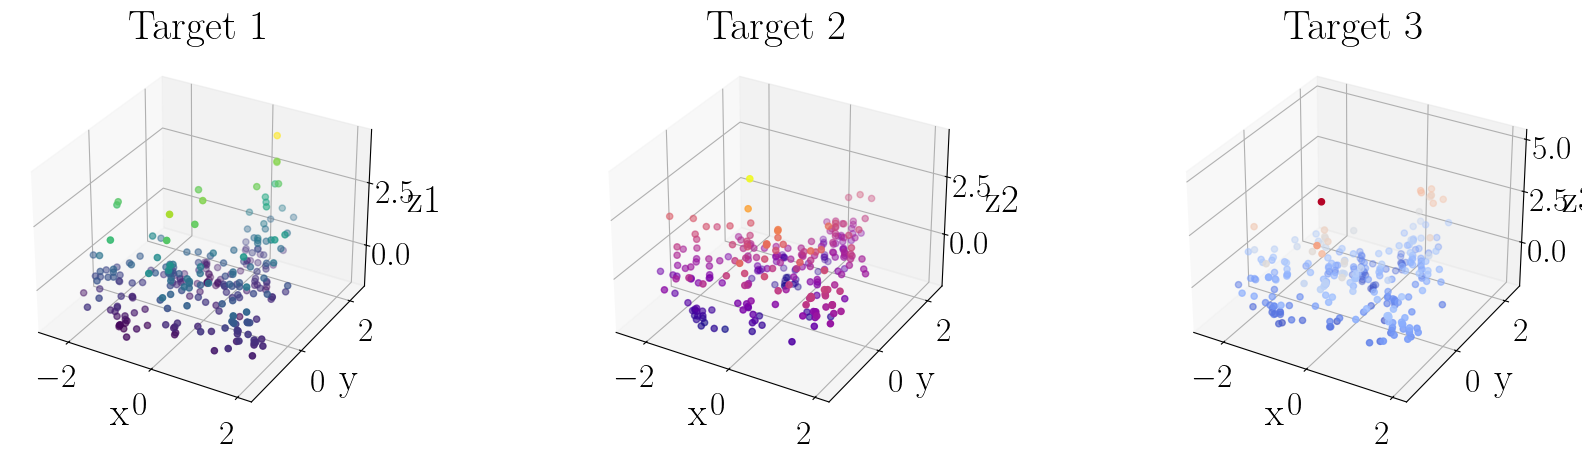

In [36]:
import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D

# Example arrays
# X_train_scaled: N x 2 (x, y)
# Y_train_scaled: N x 3 (z1, z2, z3)

# Unpack coordinates
x = X_train_scaled[:, 0]
y = X_train_scaled[:, 1]
z1 = Y_train_scaled[:, 0]
z2 = Y_train_scaled[:, 1]
z3 = Y_train_scaled[:, 2]

fig = plt.figure(figsize=(18, 5))

# First subplot
ax1 = fig.add_subplot(131, projection='3d')
ax1.scatter(x, y, z1, c=z1, cmap='viridis')
ax1.set_title('Target 1')
ax1.set_xlabel('x')
ax1.set_ylabel('y')
ax1.set_zlabel('z1')

# Second subplot
ax2 = fig.add_subplot(132, projection='3d')
ax2.scatter(x, y, z2, c=z2, cmap='plasma')
ax2.set_title('Target 2')
ax2.set_xlabel('x')
ax2.set_ylabel('y')
ax2.set_zlabel('z2')

# Third subplot
ax3 = fig.add_subplot(133, projection='3d')
ax3.scatter(x, y, z3, c=z3, cmap='coolwarm')
ax3.set_title('Target 3')
ax3.set_xlabel('x')
ax3.set_ylabel('y')
ax3.set_zlabel('z3')

plt.tight_layout()
plt.show()


In [33]:
initial_A = generate_A(d = 3, r = 2)

# Measure total time
start_total = time.time()

mogp = MOGPRegressor_NC(mean=0, length_scale=1.67, noise=0.04, A=initial_A)
mogp.fit(X_train_scaled, Y_train_scaled)

# Optimize hyperparameters
mogp.optimize_hyperparameters()
optim_lengthscale = mogp.length_scale
optim_noise = mogp.noise
optim_A = mogp.A
optim_B = optim_A @ optim_A.T

# Measure prediction time
start_pred = time.time()
mu_mogp, var_mogp = mogp.predict(X_test_scaled)
std_mogp = np.sqrt(var_mogp + mogp.noise)
end_pred = time.time()

end_total = time.time()

print(f"Total runtime: {end_total - start_total:.4f} seconds")
print(f"Prediction runtime: {end_pred - start_pred:.4f} seconds")

Optimized length_scale: 0.0664, noise: 0.259604
Optimized A: [[0.29580302 0.78150464]
 [0.81153748 0.26812008]
 [0.52402701 0.66328666]]
Optimized B: 
[[0.69824892 0.44959232 0.67337037]
 [0.44959232 0.73048146 0.60310803]
 [0.67337037 0.60310803 0.7145535 ]]
Total runtime: 10.0575 seconds
Prediction runtime: 0.5989 seconds


In [34]:
# Measure total time
start_total = time.time()
morcgp = MORCGPRegressor_NC_fixed_weights(mean = 0, length_scale=optim_lengthscale, noise = optim_noise, A=optim_A)
predictive_mean, predictive_variances = morcgp.fit(X_train_scaled, Y_train_scaled, B_weighted=optim_B, noise_weighted=optim_noise)

predictive_mean, predictive_variances = morcgp.optimize_loo_cv(weighted=True, print_opt_param = True, print_iter_param=False, update_weights=True)

start_pred = time.time()
mu_morcgp, var_morcgp = morcgp.predict(X_test_scaled)
std_morcgp = np.sqrt(var_morcgp + morcgp.noise)

end_pred = time.time()
end_total = time.time()
print(f"Total runtime: {end_total - start_total:.4f} seconds")
print(f"Prediction runtime: {end_pred - start_pred:.4f} seconds")

Optimized length_scale: 0.0657, noise: 0.118412
Optimized A: [[0.37917801 0.67467632]
 [0.70787735 0.33753093]
 [0.47267306 0.64293585]]
Optimized B: 
[[0.59896409 0.49613565 0.61300082]
 [0.49613565 0.61501747 0.55160528]
 [0.61300082 0.55160528 0.63678632]]
Total runtime: 45.6313 seconds
Prediction runtime: 0.6412 seconds


In [35]:
print(mu_mogp.reshape(-1)[:6])
print(Y_train_scaled.reshape(-1)[:6])
print(mu_morcgp.reshape(-1)[:6])

[-0.29387256 -0.56919556 -0.42947817  0.47368926  0.374435    0.48350445]
[ 0.47176892  0.19346018  0.60358281  0.02837994  1.21573739 -0.05242171]
[-0.38101812 -0.50328801 -0.43027173  0.23237642  0.30828253  0.26270236]


In [7]:
rmse_mogp = calculate_rmse(Y_test_scaled, mu_mogp)
rmse_morcgp = calculate_rmse(Y_test_scaled, mu_morcgp)

print("RMSE MOGP:", rmse_mogp)
print("RMSE MORCGP:", rmse_morcgp)

nlpd_mogp = nlpd(Y_test_scaled, mu_mogp, std_mogp**2)
nlpd_morcgp = nlpd(Y_test_scaled, mu_morcgp, std_morcgp**2)

print("NLPD MOGP:", nlpd_mogp)
print("NLPD MORCGP:", nlpd_morcgp)

RMSE MOGP: 0.9949811462609123
RMSE MORCGP: 0.9826666414947748
NLPD MOGP: 1.404920678062655
NLPD MORCGP: 1.4089243208695172


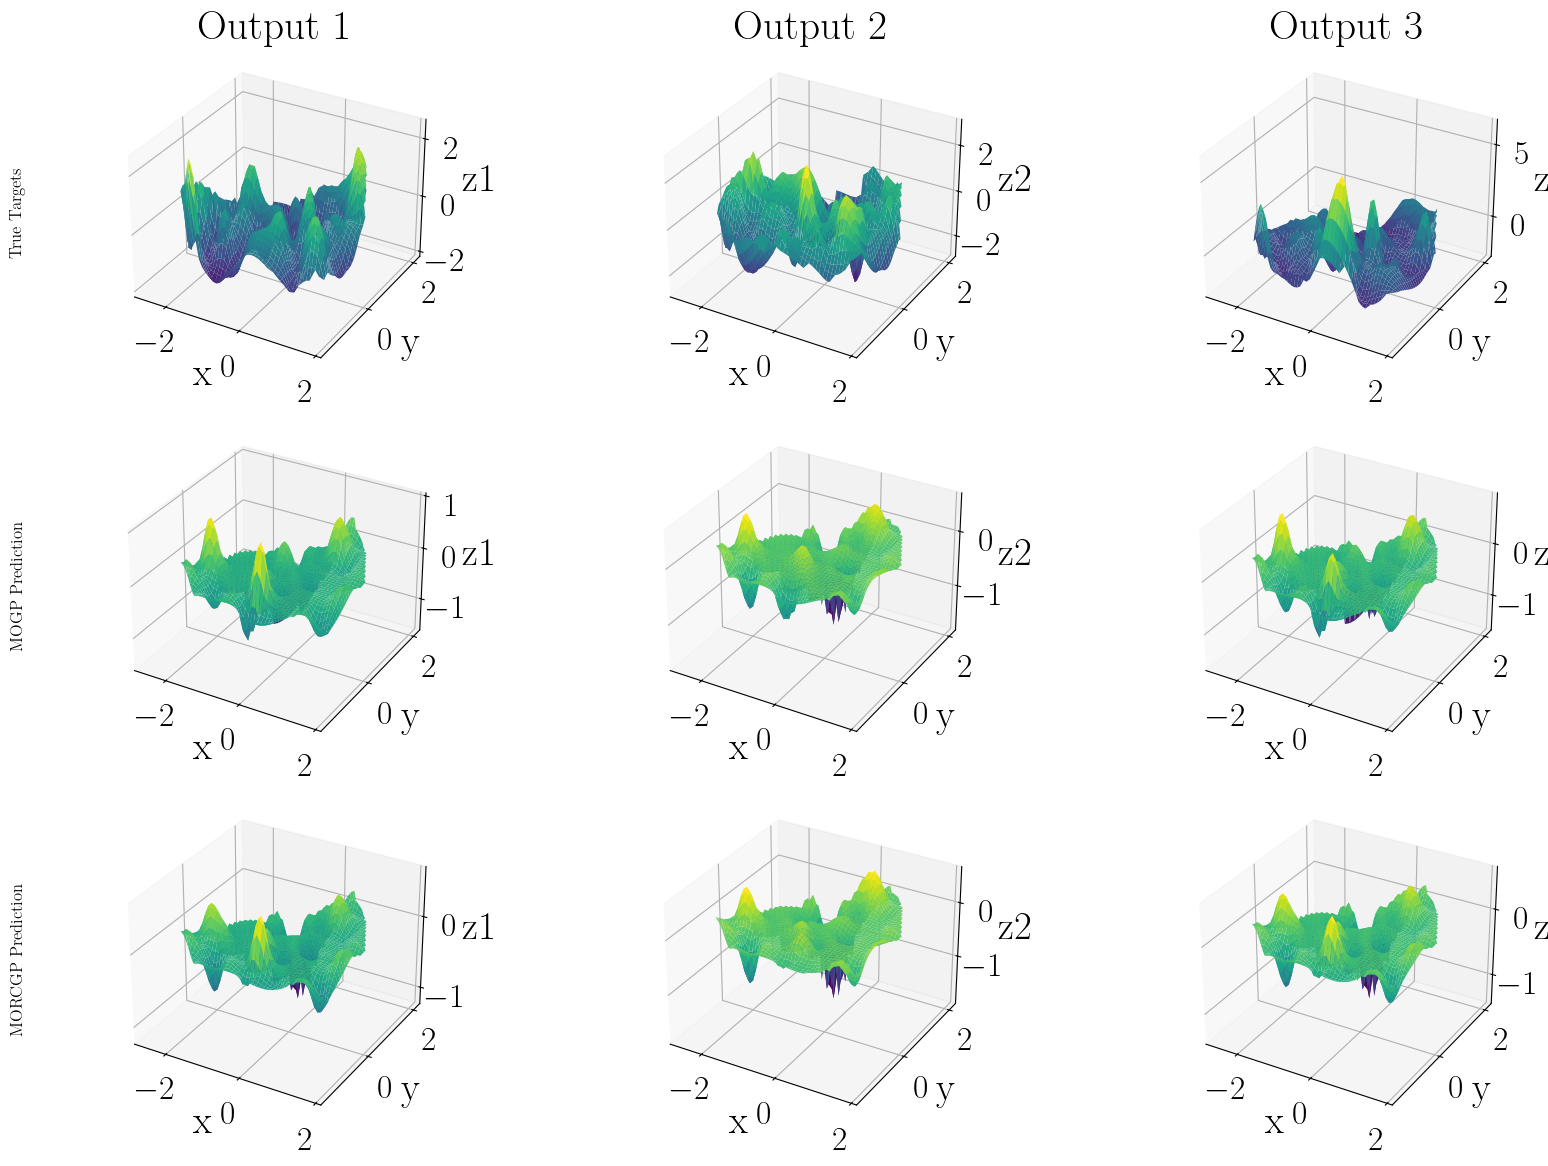

In [41]:
import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
from scipy.interpolate import griddata

# Unpack inputs
x = X_test_scaled[:, 0]
y = X_test_scaled[:, 1]

# Unpack outputs
Zs = [
    Y_test_scaled,  # Row 1: true targets
    mu_mogp,         # Row 2: MOGP predictions
    mu_morcgp        # Row 3: MORCGP predictions
]

titles_row = ['True Targets', 'MOGP Prediction', 'MORCGP Prediction']
titles_col = ['Output 1', 'Output 2', 'Output 3']

# Define grid for surface
xi = np.linspace(x.min(), x.max(), 50)
yi = np.linspace(y.min(), y.max(), 50)
X_grid, Y_grid = np.meshgrid(xi, yi)

fig = plt.figure(figsize=(18, 12))

for i in range(3):  # Row
    for j in range(3):  # Column
        ax = fig.add_subplot(3, 3, i*3 + j + 1, projection='3d')
        z = Zs[i][:, j]

        # Interpolate z values onto the grid
        Z_grid = griddata((x, y), z, (X_grid, Y_grid), method='cubic')

        # Plot surface
        surf = ax.plot_surface(X_grid, Y_grid, Z_grid, cmap='viridis', edgecolor='none')
        ax.set_xlabel('x')
        ax.set_ylabel('y')
        ax.set_zlabel(f'z{j+1}')

        if i == 0:
            ax.set_title(titles_col[j])
        if j == 0:
            ax.text2D(-0.3, 0.5, titles_row[i], transform=ax.transAxes,
                      fontsize=12, rotation=90, va='center')

plt.tight_layout()
plt.show()


## Uniform outliers

In [ ]:
# For X
scaler_X = StandardScaler()
X_train_scaled = scaler_X.fit_transform(X_train)  # fit on train and transform train
X_test_scaled = scaler_X.transform(X_test)        # transform test with train parameters

# For Y
scaler_Y = StandardScaler()
Y_train_scaled = scaler_Y.fit_transform(Y_train)  # fit on train and transform train
Y_test_scaled = scaler_Y.transform(Y_test)        # transform test with train parameters


Y_train_scaled = uniform_outliers(Y=Y_train_scaled, percent_outliers=0.1, start=6, end=9)

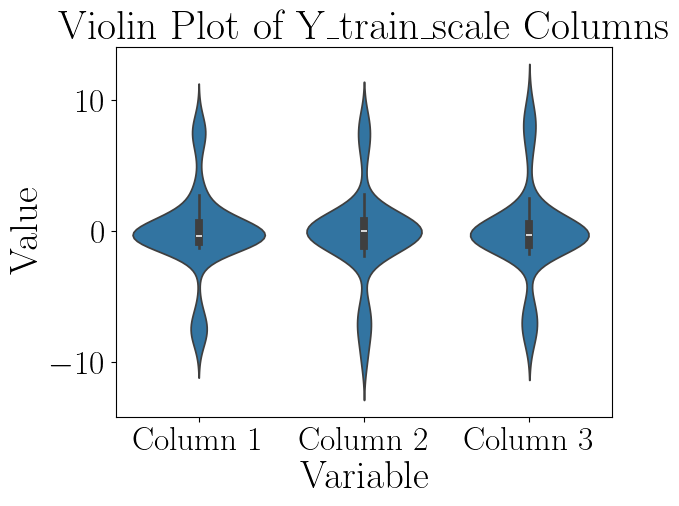

In [43]:
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import pandas as pd

# Assume Y_train_scale is a NumPy array of shape (N, 3)
# Example dummy data (remove this if you already have your array)
# Y_train_scale = np.random.randn(100, 3)

# Convert to a DataFrame for seaborn
df = pd.DataFrame(Y_train_scaled, columns=['Column 1', 'Column 2', 'Column 3'])

# Melt the DataFrame for seaborn
df_melted = df.melt(var_name='Variable', value_name='Value')

# Create the violin plot
sns.violinplot(x='Variable', y='Value', data=df_melted)

plt.title('Violin Plot of Y_train_scale Columns')
plt.show()


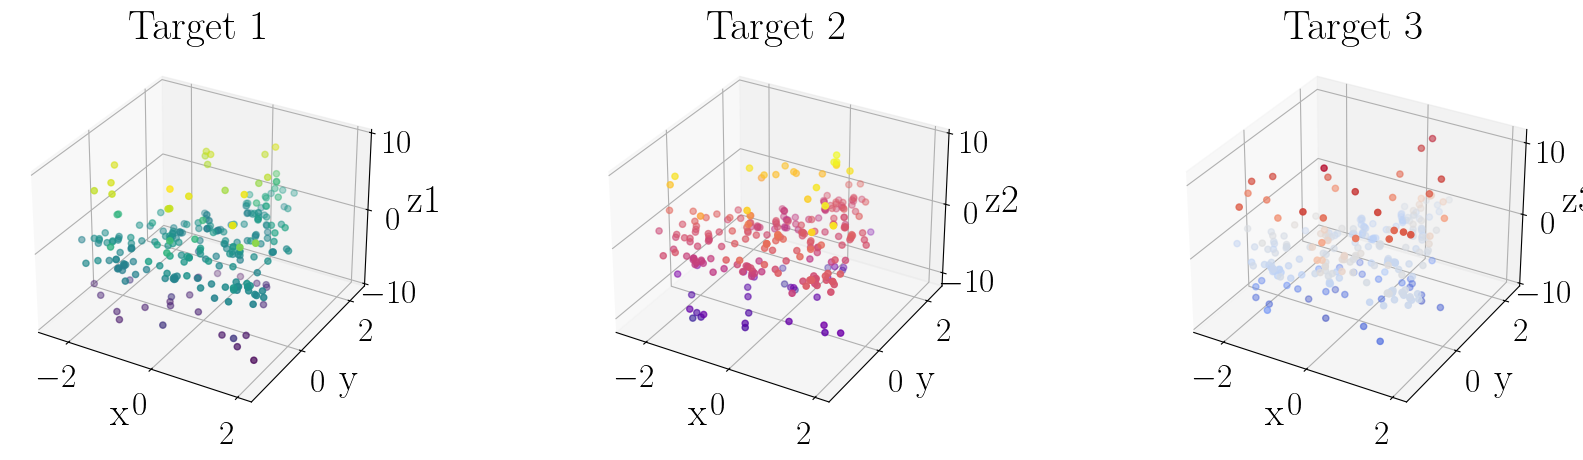

In [45]:
import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D

# Example arrays
# X_train_scaled: N x 2 (x, y)
# Y_train_scaled: N x 3 (z1, z2, z3)

# Unpack coordinates
x = X_train_scaled[:, 0]
y = X_train_scaled[:, 1]
z1 = Y_train_scaled[:, 0]
z2 = Y_train_scaled[:, 1]
z3 = Y_train_scaled[:, 2]

fig = plt.figure(figsize=(18, 5))

# First subplot
ax1 = fig.add_subplot(131, projection='3d')
ax1.scatter(x, y, z1, c=z1, cmap='viridis')
ax1.set_title('Target 1')
ax1.set_xlabel('x')
ax1.set_ylabel('y')
ax1.set_zlabel('z1')

# Second subplot
ax2 = fig.add_subplot(132, projection='3d')
ax2.scatter(x, y, z2, c=z2, cmap='plasma')
ax2.set_title('Target 2')
ax2.set_xlabel('x')
ax2.set_ylabel('y')
ax2.set_zlabel('z2')

# Third subplot
ax3 = fig.add_subplot(133, projection='3d')
ax3.scatter(x, y, z3, c=z3, cmap='coolwarm')
ax3.set_title('Target 3')
ax3.set_xlabel('x')
ax3.set_ylabel('y')
ax3.set_zlabel('z3')

plt.tight_layout()
plt.show()


In [22]:
initial_A = generate_A(d = 3, r = 2)

# Measure total time
start_total = time.time()

mogp = MOGPRegressor_NC(mean=0, length_scale=1.67, noise=0.04, A=initial_A)
mogp.fit(X_train_scaled, Y_train_scaled)

# Optimize hyperparameters
mogp.optimize_hyperparameters()
optim_lengthscale = mogp.length_scale
optim_noise = mogp.noise
optim_A = mogp.A
optim_B = optim_A @ optim_A.T
print(optim_B)

# Measure prediction time
start_pred = time.time()
mu_mogp, var_mogp = mogp.predict(X_test_scaled)
std_mogp = np.sqrt(var_mogp + mogp.noise)
end_pred = time.time()

end_total = time.time()

print(f"Total runtime: {end_total - start_total:.4f} seconds")
print(f"Prediction runtime: {end_pred - start_pred:.4f} seconds")

Optimized length_scale: 0.0728, noise: 4.947242
Optimized A: [[-0.13973672  0.79578352]
 [ 1.33311379  0.57011146]
 [ 0.33177346  0.78077733]]
Optimized B: 
[[0.65279776 0.26740036 0.5749688 ]
 [0.26740036 2.10221947 0.88742189]
 [0.5749688  0.88742189 0.71968687]]
[[0.65279776 0.26740036 0.5749688 ]
 [0.26740036 2.10221947 0.88742189]
 [0.5749688  0.88742189 0.71968687]]
Total runtime: 16.3087 seconds
Prediction runtime: 0.6013 seconds


In [23]:
# Measure total time
start_total = time.time()
morcgp = MORCGPRegressor_NC_fixed_weights(mean = 0, length_scale=optim_lengthscale, noise = optim_noise, A=optim_A)
predictive_mean, predictive_variances = morcgp.fit(X_train_scaled, Y_train_scaled, B_weighted=optim_B, noise_weighted=optim_noise)

predictive_mean, predictive_variances = morcgp.optimize_loo_cv(weighted=True, print_opt_param = False, print_iter_param=False, update_weights=True)

start_pred = time.time()
mu_morcgp, var_morcgp = morcgp.predict(X_test_scaled)
std_morcgp = np.sqrt(var_morcgp + morcgp.noise)

end_pred = time.time()
end_total = time.time()
print(f"Total runtime: {end_total - start_total:.4f} seconds")
print(f"Prediction runtime: {end_pred - start_pred:.4f} seconds")

Total runtime: 35.7473 seconds
Prediction runtime: 0.6827 seconds


In [31]:
print(mu_mogp.reshape(-1)[:6])
print(Y_train_scaled.reshape(-1)[:6])
print(mu_morcgp.reshape(-1)[:6])

[-0.22579368 -1.62885263 -0.7014906  -0.09746543 -0.33733956 -0.18314395]
[ 0.47176892  0.19346018  0.60358281  0.02837994  1.21573739 -0.05242171]
[-0.0154671  -0.24549921 -0.04194147 -0.01859605  0.00038909 -0.01617408]


In [24]:
rmse_mogp = calculate_rmse(Y_test_scaled, mu_mogp)
rmse_morcgp = calculate_rmse(Y_test_scaled, mu_morcgp)

print("RMSE MOGP:", rmse_mogp)
print("RMSE MORCGP:", rmse_morcgp)

nlpd_mogp = nlpd(Y_test_scaled, mu_mogp, std_mogp**2)
nlpd_morcgp = nlpd(Y_test_scaled, mu_morcgp, std_morcgp**2)

print("NLPD MOGP:", nlpd_mogp)
print("NLPD MORCGP:", nlpd_morcgp)

RMSE MOGP: 0.9845507387438929
RMSE MORCGP: 0.9777737970723119
NLPD MOGP: 1.8978218422672823
NLPD MORCGP: 1.5107970004346563


## Asymmetric outliers

In [ ]:
# For X
scaler_X = StandardScaler()
X_train_scaled = scaler_X.fit_transform(X_train)  # fit on train and transform train
X_test_scaled = scaler_X.transform(X_test)        # transform test with train parameters

# For Y
scaler_Y = StandardScaler()
Y_train_scaled = scaler_Y.fit_transform(Y_train)  # fit on train and transform train
Y_test_scaled = scaler_Y.transform(Y_test)        # transform test with train parameters

Y_train_scaled = asymmetric_outliers_c1(Y=Y_train_scaled, percent_outliers=0.1, start=2, end=3)

In [ ]:
initial_A = generate_A(d = 2, r = 2)

# Measure total time
start_total = time.time()

mogp = MOGPRegressor_NC(mean=0, length_scale=1.67, noise=0.04, A=initial_A)
mogp.fit(X_train_scaled, Y_train_scaled)

# Optimize hyperparameters
mogp.optimize_hyperparameters()
optim_lengthscale = mogp.length_scale
optim_noise = mogp.noise
optim_A = mogp.A
optim_B = optim_A @ optim_A.T

# Measure prediction time
start_pred = time.time()
mu_mogp, var_mogp = mogp.predict(X_test_scaled)
std_mogp = np.sqrt(var_mogp + mogp.noise)
end_pred = time.time()

end_total = time.time()

print(f"Total runtime: {end_total - start_total:.4f} seconds")
print(f"Prediction runtime: {end_pred - start_pred:.4f} seconds")

In [ ]:
# Measure total time
start_total = time.time()
morcgp = MORCGPRegressor_NC_fixed_weights(mean = 0, length_scale=optim_lengthscale, noise = optim_noise, A=optim_A)
predictive_mean, predictive_variances = morcgp.fit(X_train_scaled, Y_train_scaled, B_weighted=optim_B, noise_weighted=optim_noise)

predictive_mean, predictive_variances = morcgp.optimize_loo_cv(weighted=True, print_opt_param = False, print_iter_param=False, update_weights=True)

start_pred = time.time()
mu_morcgp, var_morcgp = morcgp.predict(X_test_scaled)
std_morcgp = np.sqrt(var_morcgp + morcgp.noise)

end_pred = time.time()
end_total = time.time()
print(f"Total runtime: {end_total - start_total:.4f} seconds")
print(f"Prediction runtime: {end_pred - start_pred:.4f} seconds")

# Air Quality Dataset

In [87]:
import seaborn as sns

df = sns.load_dataset('air_quality')
print(df.head())


ValueError: 'air_quality' is not one of the example datasets.